In [1]:
# How to generate random arbitrary state
from Circuit import Circuit
from Circuit_ops import zero_state, apply, state_prob_plot
from Circuit_ops import find_fidelities, plot_fidelities, save_fidelities, read_fidelities
from Circuit_ops import find_prob, plot_prob
from Circuit_ops import int_to_bit_str, bit_str_to_int
from Error_dist import error_dist
import time
from numpy import *
import numpy as np
from numpy import linalg as LA 
# import cupy as cp
import matplotlib.pyplot as plt

In [2]:
N = 5

# Generate random amplitude vector (normalized) and phase vector (0 to 2 pi):
def random_state(N):
    
    a = random.rand(2 ** N) 
    p = random.rand(2 ** N)
    
    return a / sqrt(sum(a ** 2)), 2 * pi * p

# Show state vector given amplitude and phase vector
def get_state(a, p):
    return a * exp(1j * p)

# Find alpha angles that removes relative phases
def find_phase_alphas(p, N):

    p1 = p.copy()

    alpha = []
    
    for i in arange(N-1, 0, -1):
        
        p1 = p1.reshape([2 ** i, 2])
        
        p2 = zeros([2 ** i])
        p2 = average(p1, axis=1)

        p1 = p1.swapaxes(0, 1)
        alpha.append(p1[0] - p1[1])
        
        p1 = p2
    
    # Last step
    alpha.append(p1[0] - p1[1])
    
    return alpha

# Find alpha angles that equalizes amplitudes
def find_amp_alphas(a, N):

    a1 = a.copy()

    alpha = []
    
    for i in arange(N-1, 0, -1):
        a1 = a1.reshape([2 ** i, 2]).swapaxes(0,1)
        a2 = zeros([2 ** i])
        
        a_sqrt = sqrt(0.5 * (a1[0]**2 + a1[1]**2))
    
        # Do we have to worry about division by zero?
        alpha.append(pi/2 - 2 * arctan(a1[1] / a1[0]))
        
        a1 = a_sqrt
    
    # Last step
    alpha.append(pi/2 - 2 * arctan(a1[1] / a1[0]))
    
    return alpha

# Convert alpha's to theta's
def angle_conversion(alphas, N):
    
    thetas = []
    
    for K in arange(N - 1, 0, -1):
        alpha_group = alphas[N - 1 - K]
        
        T = zeros([2 ** K, 2 ** K])
        
        for i in range(2 ** K):
            for j in range(2 ** K):
                # See M. Mottonen et al eq (3)
                T[i][j] = (-1) ** (dot(int_to_bit_str(j, K), int_to_bit_str(i^(i>>1), K)))
        
        theta_group = (matmul(T / 2 ** K, alpha_group)) % (2 * pi)
        thetas.append(theta_group)
    
    thetas.append(alphas[N - 1])
    
    return thetas

# Build circuit
def ucr_gate_sequence(phase_thetas, amp_thetas, N):
    gates = []

    # Step 1: UCR about Z-axis for removing relative phase
    for k in arange(N - 1, 0, -1):
        # ucr stands for uniformly controlled rotation
        ucr = [0] * 2 ** (k + 1)
        for i in range(1, k):
            for j in arange(2 ** i - 1, 2 ** (k + 1), 2 ** (i + 1)):
                ucr[j] = ['CNOT', [k - i, k], None, None]

        ucr[2 ** k - 1] = ['CNOT', [0, k], None, None]
        ucr[2 ** (k + 1) - 1] = ['CNOT', [0, k], None, None]

        # Append theta gates
        for i in range(2 ** k):
            ucr[2 * i] = ['Z', k, phase_thetas[N - 1 - k][i], None]

        gates += ucr

    gates.append(['Z', 0, phase_thetas[N - 1], None])

    # Step 2: UCR about Y-axis for equalizing amplitude
    for k in arange(N - 1, 0, -1):
        ucr = [0] * 2 ** (k + 1)
        for i in range(1, k):
            for j in arange(2 ** i - 1, 2 ** (k + 1), 2 ** (i + 1)):
                ucr[j] = ['CNOT', [k - i, k], None, None]

        ucr[2 ** k - 1] = ['CNOT', [0, k], None, None]
        ucr[2 ** (k + 1) - 1] = ['CNOT', [0, k], None, None]

        # Append theta gates
        for i in range(2 ** k):
            ucr[2 * i] = ['Y', k, amp_thetas[N - 1 - k][i], None]

        gates += ucr

    gates.append(['Y', 0, amp_thetas[N - 1], None])

    # Step 3: Remove superposition
    for i in range(N):
        gates.append(['Y', i, -pi/2, None])
    
    return gates

# Generate random state
N = 1
a, p = random_state(N)

amp_alphas = find_amp_alphas(a,N)
phase_alphas = find_phase_alphas(p,N)

print('State amplitudes, phases, and required rotation angles')
print(a, p)
print(amp_alphas, phase_alphas)

# Check that the suggested rotation angles indeed equalize amplitudes and phases
circ = Circuit(N)
circ.init_state = get_state(a, p)

circ.Z(0, phase_alphas[0])
circ.Y(0, amp_alphas[0])

final_state = circ.compute()
final_state[0]

print(f'Equalized state: {final_state[0]}')

State amplitudes, phases, and required rotation angles
[0.88741867 0.46096431] [2.91690777 1.98728895]
[0.6126332419579062] [0.9296188230789111]
Equalized state: [-0.54558083+0.44982391j -0.54558083+0.44982391j]


In [3]:
N = 3
a, p = random_state(N)

phase_alphas = find_phase_alphas(p,N)
amp_alphas = find_amp_alphas(a,N)

print(f'Phase alphas: {phase_alphas}')
print(f'Amplitude alphas: {amp_alphas}')

phase_thetas = angle_conversion(phase_alphas, N)
amp_thetas = angle_conversion(amp_alphas, N)

print(f'Phase thetas: {phase_thetas}')
print(f'Amplitude thetas: {amp_thetas}')

Phase alphas: [array([ 0.27141351,  1.15933994, -2.9314264 ,  0.55631721]), array([ 4.22631112, -2.36513861]), -1.8286605491845567]
Amplitude alphas: [array([-0.42851975, -0.02989039,  0.16486479,  1.23390143]), array([-0.07738243,  0.55065667]), -0.013466362719519287]
Phase thetas: [array([6.04709637, 5.1892678 , 0.64995429, 0.95146566]), array([0.93058625, 3.29572487]), -1.8286605491845567]
Amplitude thetas: [array([0.23508902, 5.91626881, 0.16760182, 5.81889122]), array([0.23663712, 5.96916576]), -0.013466362719519287]


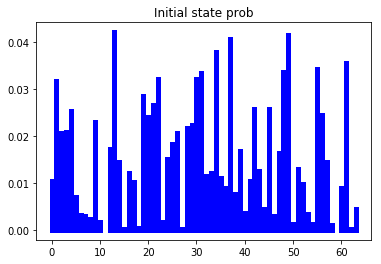

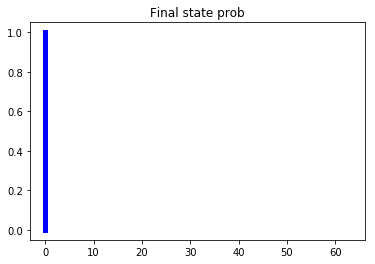

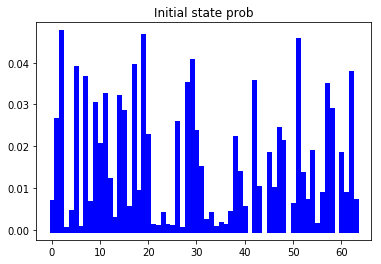

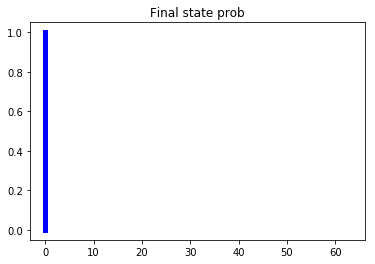

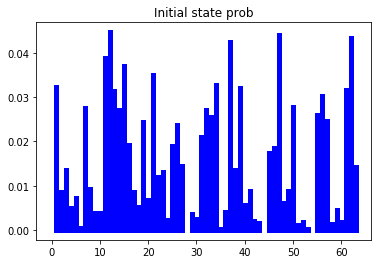

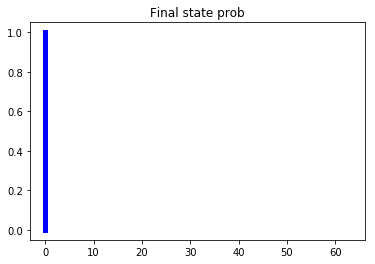

In [4]:
# Build circuit that equalizes phase and then amplitude for a random state

N = 6
reps = 3

def random_asg_angles(N):
    
    a, p = random_state(N)
    
    phase_alphas = find_phase_alphas(p, N)
    amp_alphas = find_amp_alphas(a, N)
    
    phase_thetas = angle_conversion(phase_alphas, N)
    amp_thetas = angle_conversion(amp_alphas, N)
    
    return a, p, amp_thetas, phase_thetas

def reverse_circuit(a, p, amp_thetas, phase_thetas, N):
    # Create circuit and input gates
    circ = Circuit(N)
    circ.Z_is_native = True
    circ.init_state = get_state(a, p)
    
    # Input gates
    circ.ideal_gates = ucr_gate_sequence(phase_thetas, amp_thetas, N)
    circ.runs = 2
    final_states = circ.compute()
    
    # Check state probability
    state_prob_plot(circ.init_state, title="Initial state prob")
    state_prob_plot(final_states[0], title="Final state prob")
    
    return final_states

for i in range(reps):
    a, p, amp_thetas, phase_thetas = random_asg_angles(N)
    final_states = reverse_circuit(a, p, amp_thetas, phase_thetas, N)

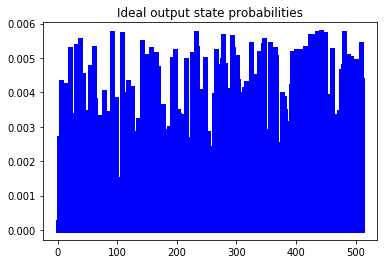

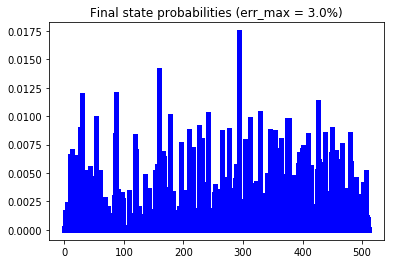

Fidelity = 0.5598994613038466


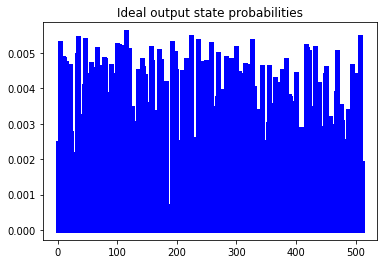

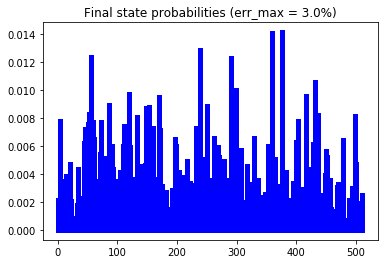

Fidelity = 0.5936379667171181


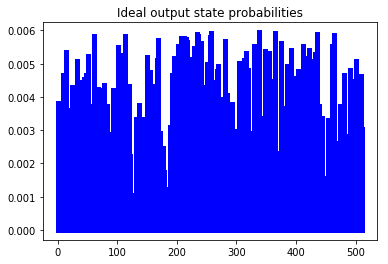

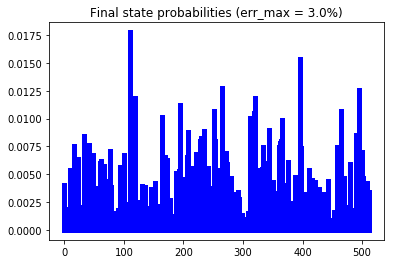

Fidelity = 0.5432953043395787


In [5]:
# Reverse circuit will generate specific state from zero state
N = 9
err = 0.03
reps = 3

def asg_circuit(a, p, amp_thetas, phase_thetas, N):

    circ = Circuit(N)
    circ.Z_is_native = True
    circ.init_state = zero_state(N)

    gates = ucr_gate_sequence(phase_thetas, amp_thetas, N)
    gates.reverse()
    for gate in gates:
        if gate[2] != None:
            # Optional gate error
            gate[2] *= -1 + err * error_dist(1)
    
    circ.ideal_gates = gates
    circ.runs = 2
    final_states = circ.compute()
    
    # Check state probability
    ideal_final_state = get_state(a, p)
    state_prob_plot(ideal_final_state, 'Ideal output state probabilities')
    state_prob_plot(final_states[0], f'Final state probabilities (err_max = {err * 100}%)')
    print(f'Fidelity = {find_fidelities(final_states, ideal_final_state)[0]}')
    
    return final_states

for i in range(reps):
    a, p, amp_thetas, phase_thetas = random_asg_angles(N)
    final_states = asg_circuit(a, p, amp_thetas, phase_thetas, N)

In [6]:
# Other problems
# Less theta's than necessary (not fully linearly independent alphas) --> "depth of entanglement?"
# How to evenly spread thetas? (randomly mod 2 * pi alphas)
# Gate reverse: why does not multiplying -1 not make a difference?

In [7]:
# Reference for parallel execution

# # Write down circuit
# def parallel_circ(sim_runs=1, err=[0,0,0], fixed_err=[0,0,0]):
#     # Initialize simple circuit
#     circ = stab_meas_circ([0,0,0,0,0,0])
    
#     # Initialize native and noisy gates
#     circ.compute()
    
#     # Create new circuit with custom gates
#     circ.init_state = zero_state(N)
#     circ.runs = 64 * sim_runs

#     # Edit noisy gates
#     for i in range(0, 6):
#         gate_angles = array([])
        
#         for k in range(sim_runs):
#             for j in range(64):
#                 gate_angles = concatenate((gate_angles, (pi / 2) * (-1) ** int_to_bit_str(j, N-1)[i] * (1 + err[0] * error_dist(1)))) 
#         circ.noisy_gates[i][2][0] = gate_angles
#         circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

#     for i in range(6, 12):
#         # Fixed errors and time-dependent errors
#         circ.noisy_gates[i][2][0] = - pi / 2 \
#                                     * (1 + fixed_err[2] * repeat(error_dist(sim_runs), 64))  \
#                                     * (1 + err[2] * error_dist(64 * sim_runs))                  
        
# #         circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * runs), 
# #                                     pi / 2 * err[1] * error_dist(64 * runs)]
#         circ.noisy_gates[i][3] = [pi / 2 * err[1] * error_dist(64 * sim_runs)
#                                   + pi / 2 * fixed_err[1] * repeat(error_dist(sim_runs), 64), 
#                                     pi / 2 * err[1] * error_dist(64 * sim_runs)
#                                   + pi / 2 * fixed_err[1] * repeat(error_dist(sim_runs), 64)]

#     for i in range(12, 18):
#         circ.noisy_gates[i][2][0] = - pi / 2 * (1 + err[0] * error_dist(64 * sim_runs))
#         circ.noisy_gates[i][3][0] = pi / 2 * (1 + err[1] * error_dist(64 * sim_runs))

#     return circ

# def run_parallel_circ(sim_runs, err, fixed_err):
# #     start = time.time()
    
#     circ0 = parallel_circ()
#     ideal_states = circ0.compute(compile_gates=False)
    
#     circ1 = parallel_circ(sim_runs, err, fixed_err)
#     final_states = circ1.compute(compile_gates=False)

# #     print(f"Time elapsed = {time.time() - start}")
    
#     return final_states, ideal_states, circ1

# def fid_dist(final_states, ideal_states, title='', plot=True, analyze=False):
    
#     results = []
    
#     for i in range(2 ** (N - 1)):
#         # -- Getting the correct ancilla --
#         measured_qubits = [6]
        
#         sub_state = zero_state(1) * 0
#         index = (1 + sum(int_to_bit_str(i, N-1))) % 2
#         sub_state[index] = 1
        
#         probs = find_prob(measured_qubits, sub_state, final_states[i::64])
#         results.append(probs)
    
#     results = swapaxes(array(results), 0, 1)
        
    
#     if plot:
#         plt.figure(figsize=(12,6))
#         plt.title(f"Probability of getting correct ancilla qubit VS input bit string" if title=='' else title)
#         plt.plot(results)
#     if analyze:
#         stat_analysis(results)
    
#     return results